In [2]:
import pandas as pd, numpy as np
import vivarium_output_loader as vol
import lsff_output_processing as lop

!whoami
!date

ndbs
Mon Mar 30 13:18:49 PDT 2020


In [3]:
%load_ext autoreload
%autoreload 2

# Check the effect size (measured as a risk ratio) of folic acid fortification on NTDs

## 1. Load all count space data tables and see what they are

In [4]:
base_directory = '/share/costeffectiveness/results/vivarium_conic_lsff/v4.0_folic_acid_fortification'

locations_rundates = {
    'Ethiopia': '2020_03_18_23_04_26',
    'India': '2020_03_18_23_04_36',
    'Nigeria': '2020_03_18_23_04_42',
}

In [5]:
data = vol.load_all_transformed_count_data(base_directory, locations_rundates)

In [6]:
[k for k in data.keys() if k[0] == 'nigeria']

[('nigeria', 'gestational_age'),
 ('nigeria', 'transition_count'),
 ('nigeria', 'deaths'),
 ('nigeria', 'state_person_time'),
 ('nigeria', 'births_with_ntd'),
 ('nigeria', 'population'),
 ('nigeria', 'person_time'),
 ('nigeria', 'ylls'),
 ('nigeria', 'ylds'),
 ('nigeria', 'births'),
 ('nigeria', 'birth_weight')]

## 2. Load NTD births and live births tables

In [7]:
ntd_births = data[('nigeria', 'births_with_ntd')]
ntd_births.head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births_with_ntds,21,baseline,44.0
1,2020,female,false,live_births_with_ntds,21,folic_acid_fortification_scale_up,35.0
2,2020,female,false,live_births_with_ntds,29,baseline,55.0
3,2020,female,false,live_births_with_ntds,29,folic_acid_fortification_scale_up,44.0
4,2020,female,false,live_births_with_ntds,55,baseline,60.0


In [8]:
live_births = data[('nigeria', 'births')]
live_births.head()

,year,sex,fortification_group,measure,input_draw,scenario,value
0,2020,female,false,live_births,21,baseline,20286.0
1,2020,female,false,live_births,21,folic_acid_fortification_scale_up,16490.0
2,2020,female,false,live_births,29,baseline,20252.0
3,2020,female,false,live_births,29,folic_acid_fortification_scale_up,16478.0
4,2020,female,false,live_births,55,baseline,20386.0


## 3. Compute conditional risk of NTDs in fortified and unfortified groups

In [9]:
def conditional_risk_of_ntds(births_with_ntd, live_births, conditioned_on, multiplier=1):
    
    # Columns in both dataframes are:
    # ['year', 'sex', 'fortification_group', 'measure', 'input_draw', 'scenario', 'value']
    
    # The index columns will NOT be aggregated over
    index_columns = ['input_draw', 'scenario'] + conditioned_on
    
    # In both dataframes, group by the index columns, and aggregate
    #'value' column over remaining columns by summing
    births_with_ntd = births_with_ntd.groupby(index_columns).value.sum()
    live_births = live_births.groupby(index_columns).value.sum()
    
    # Divide the two pandas Series to get birth prevalence
    # in each subgroup we conditioned on.
    # Multiply by the multiplier to get desired units (e.g. per 1000 live births)
    ntd_risk = multiplier * births_with_ntd / live_births
    
    # Drop any rows where we divided by 0 because there were no births
    ntd_risk.dropna(inplace=True)
    
    return ntd_risk.reset_index()

# I'm not sure how to write a good general version of this function...
# It would probably be better to compute this directly from the raw data, since
# I think you need to match up the index columns with the conditioning correctly.
def relative_risk_of_ntds(conditional_ntd_risk, numerator_query, denominator_query):
    numerator = conditional_ntd_risk.query(numerator_query)

In [10]:
conditioned_on = ['year', 'fortification_group']
multiplier = 1000

conditional_ntd_risk = conditional_risk_of_ntds(
    ntd_births, live_births, conditioned_on, multiplier)
conditional_ntd_risk.head()

,input_draw,scenario,year,fortification_group,value
0,21,baseline,2020,false,2.710093
1,21,baseline,2020,true,0.819001
2,21,baseline,2021,false,2.525741
3,21,baseline,2021,true,2.413839
4,21,baseline,2022,false,2.326418


In [11]:
conditional_ntd_risk.shape

(500, 5)

## 3a. Test the function in the module

Yes, looks like I copied it over correctly

In [13]:
conditioned_on = ['year', 'fortification_group']
multiplier = 1000

conditional_ntd_risk2 = lop.conditional_risk_of_ntds(
    ntd_births, live_births, conditioned_on, multiplier)

conditional_ntd_risk2.head()

,input_draw,scenario,year,fortification_group,value
0,21,baseline,2020,false,2.710093
1,21,baseline,2020,true,0.819001
2,21,baseline,2021,false,2.525741
3,21,baseline,2021,true,2.413839
4,21,baseline,2022,false,2.326418


In [15]:
conditional_ntd_risk2.equals(conditional_ntd_risk)

True

## 4. See what the conditional risks look like in the baseline scenario

In [16]:
conditional_ntd_risk.query('scenario == "baseline"').groupby(
    conditioned_on).value.describe(percentiles=[0.025, 0.975])

count      mean       std       min      2.5%  \
year fortification_group                                                  
2020 false                 25.0  2.679439  0.418728  1.932944  2.053354   
     true                  25.0  1.625869  0.825508  0.267237  0.535058   
2021 false                 25.0  2.639663  0.274397  1.934517  2.095934   
     true                  25.0  1.640869  0.428007  0.691946  0.959717   
2022 false                 25.0  2.634820  0.268929  2.226763  2.281330   
     true                  25.0  1.740682  0.472118  0.997009  1.010502   
2023 false                 25.0  2.677424  0.237874  2.341781  2.369799   
     true                  25.0  1.659422  0.577847  0.718047  0.861068   
2024 false                 25.0  2.624014  0.271749  2.215463  2.268329   
     true                  25.0  1.438869  0.360530  0.809935  0.831445   

                               50%     97.5%       max  
year fortification_group                                
2020 false                2.617172  3.622014  3.674160  
     true                 1.436782  3.239306  3.557814  
2021 false                2.618341  3.093227  3.283296  
     true                 1.691638  2.482341  2.585093  
2022 false                2.622809  3.208310  3.231619  
     true                 1.719057  2.473734  2.490823  
2023 false                2.634175  3.183101  3.270705  
     true                 1.567965  2.583706  2.584350  
2024 false                2.552286  3.227151  3.424863  
     true                 1.426737  2.077186  2.138752

## 5. Use the conditional risks to compute the risk ratio of the unfortified group to the fortified group for each year

In [17]:
conditional_ntd_risk.head()

,input_draw,scenario,year,fortification_group,value
0,21,baseline,2020,false,2.710093
1,21,baseline,2020,true,0.819001
2,21,baseline,2021,false,2.525741
3,21,baseline,2021,true,2.413839
4,21,baseline,2022,false,2.326418


In [18]:
conditional_ntd_risk.scenario.unique()

array(['baseline', 'folic_acid_fortification_scale_up'], dtype=object)

In [19]:
index_cols = ['year', 'input_draw', 'scenario']
# scenario = 'folic_acid_fortification_scale_up'

numerator = conditional_ntd_risk.query('fortification_group == "false"')
denominator = conditional_ntd_risk.query('fortification_group == "true"')

numerator = numerator.set_index(index_cols).value
denominator = denominator.set_index(index_cols).value

rr = numerator / denominator
rr = rr.reset_index()
rr.head()

,year,input_draw,scenario,value
0,2020,21,baseline,3.309023
1,2021,21,baseline,1.046358
2,2022,21,baseline,1.028824
3,2023,21,baseline,1.241010
4,2024,21,baseline,2.045658


# 6. Check the computed risk ratios:

### All the *medians* should all be close to 1.71 -- looks reasonable

In [20]:
rr.groupby(['year', 'scenario']).value.describe(percentiles=[0.025, 0.975])

count      mean       std       min  \
year scenario                                                                 
2020 baseline                            25.0  2.252970  1.772892  0.659186   
     folic_acid_fortification_scale_up   25.0  1.878565  0.874925  1.056682   
2021 baseline                            25.0  1.743620  0.613622  0.950200   
     folic_acid_fortification_scale_up   25.0  1.793471  0.378173  1.221099   
2022 baseline                            25.0  1.637786  0.522246  0.982970   
     folic_acid_fortification_scale_up   25.0  1.629987  0.371770  1.100790   
2023 baseline                            25.0  1.811697  0.661927  1.011476   
     folic_acid_fortification_scale_up   25.0  1.657036  0.342625  1.076682   
2024 baseline                            25.0  1.942535  0.545916  1.200679   
     folic_acid_fortification_scale_up   25.0  1.853069  0.380362  1.144048   

                                            2.5%       50%     97.5%       max  
year scenario                                                                   
2020 baseline                           0.817351  1.898543  6.105179  9.681759  
     folic_acid_fortification_scale_up  1.107890  1.639157  3.982885  5.358537  
2021 baseline                           0.960358  1.689782  3.254397  3.809154  
     folic_acid_fortification_scale_up  1.242550  1.721222  2.580665  2.787608  
2022 baseline                           1.010483  1.590231  2.779427  2.981564  
     folic_acid_fortification_scale_up  1.111189  1.527670  2.304019  2.313689  
2023 baseline                           1.057727  1.730006  3.213726  3.713823  
     folic_acid_fortification_scale_up  1.157370  1.610126  2.362367  2.810660  
2024 baseline                           1.228655  1.773350  3.044771  3.109542  
     folic_acid_fortification_scale_up  1.355131  1.796718  2.780462  2.808133

In [21]:
rr.shape

(250, 4)

## 7. Plot the distribution of risk ratios over all 5 years, in baseline, intervention, and both

The risk ratio should be independent of year and scenario, so we should get the same distribution no mater how we slice the data or if we aggregate it all together (e.g. over year as in the first two graphs, or over everything like the final graph below).

The samples in all of the graphs below should follow a lognormal distribution with median = 1.71, 97.5%-percentile = 2.04, and 2.5%-percentile = 1.43.

Hmm, the values look more spread out than they should...

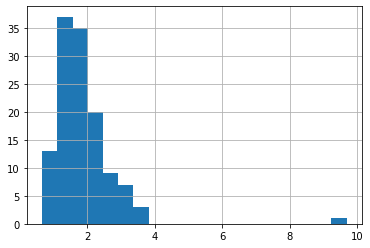

In [22]:
scenario = 'baseline'
# scenario = 'folic_acid_fortification_scale_up'
rr.query('scenario == @scenario').value.hist(bins=20)

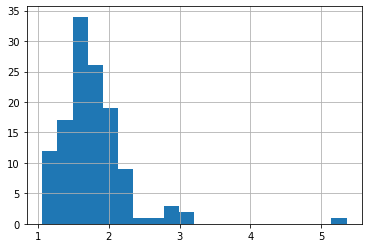

In [23]:
scenario = 'folic_acid_fortification_scale_up'
rr.query('scenario == @scenario').value.hist(bins=20)

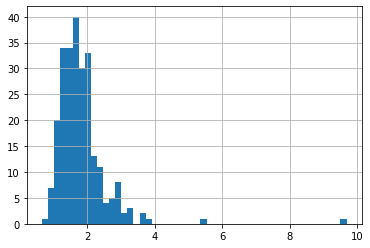

In [24]:
rr.value.hist(bins=50)

In [25]:
rr.value.describe(percentiles=[0.025, 0.975])

count    250.000000
mean       1.820074
std        0.770526
min        0.659186
2.5%       1.017989
50%        1.710835
97.5%      3.240121
max        9.681759
Name: value, dtype: float64